In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import helper_functions

In [2]:
mosquito_df = pd.read_csv('data_files/Mosquito_Trap_Data.csv')
weather_df = pd.read_csv('data_files/weather_stats_edmonton.csv')

In [3]:
mosquito_df_prep = helper_functions.clean_mosquito_df(mosquito_df, gender=None) # both male and female combined
weather_df_prep = helper_functions.clean_weather_df(weather_df)
weather_df_prep = helper_functions.preprocess_weather(weather_df_prep, ['2D', '7D', '14D'])

merged_df = helper_functions.merge_mosquito_weather_data(mosquito_df_prep, weather_df_prep)

In [7]:
merged_df

,Count,pressure_station,pressure_sea,wind_dir_10s,wind_speed,wind_gust,relative_humidity,dew_point,temperature,pressure_station_2D,...,wind_speed_14D,relative_humidity_2D,relative_humidity_7D,relative_humidity_14D,dew_point_2D,dew_point_7D,dew_point_14D,temperature_2D,temperature_7D,temperature_14D
Trap Date,,,,,,,,,,,,,,,,,,,,,
2017-05-09,26,93.55,101.5,29.0,11.0,0.0,22.0,-3.8,18.6,93.612292,...,12.113095,41.395833,59.267857,56.157738,0.927083,3.150595,2.498214,14.447917,12.089881,12.377083
2017-05-16,29,92.83,100.7,6.0,22.0,0.0,59.0,3.4,11.1,93.409792,...,12.854167,71.812500,53.047619,50.431548,1.991667,1.845833,2.751786,7.277083,12.664286,14.407738
2017-05-23,523,93.91,101.7,26.0,8.0,0.0,25.0,3.3,24.5,92.265000,...,14.586310,49.333333,47.815476,50.550595,5.620833,3.657738,5.441667,18.733333,16.151190,17.024702
2017-05-30,360,94.14,102.0,10.0,12.0,0.0,23.0,-0.5,21.2,93.402708,...,14.574405,34.979167,53.285714,55.666667,3.631250,7.225595,7.202976,19.854167,17.898214,17.368155
2017-06-06,1649,93.87,101.7,32.0,20.0,1.0,25.0,0.7,21.4,93.929375,...,12.583333,39.208333,58.047619,60.071429,4.354167,7.180357,7.297917,19.310417,16.838095,16.211310
2017-06-13,2959,92.64,100.4,19.0,18.0,0.0,33.0,7.4,24.6,92.965833,...,13.970238,68.520833,62.095238,57.407738,9.960417,7.415476,6.641369,16.412500,15.584524,15.992560
2017-06-20,1868,93.70,101.6,21.0,9.0,0.0,31.0,3.6,21.6,93.178125,...,14.895833,54.958333,52.720238,59.098214,5.891667,5.867262,8.280357,15.835417,16.400595,17.217857
2017-06-27,767,92.42,100.1,7.0,4.0,0.0,27.0,8.7,29.5,92.640000,...,11.991071,69.625000,65.476190,59.898810,9.364583,10.693452,10.597619,15.366667,18.035119,19.446131
2017-07-04,1776,93.45,101.3,32.0,18.0,0.0,48.0,7.8,18.9,93.711250,...,12.214286,43.395833,54.321429,60.776786,5.600000,10.501786,11.030060,18.900000,20.857143,19.518155


<AxesSubplot:xlabel='temperature_14D', ylabel='Count'>

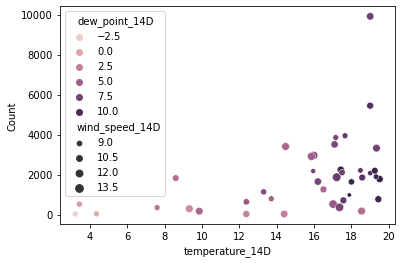

In [15]:
sns.scatterplot(data=merged_df, x='temperature_14D', y='Count', hue='dew_point_14D', size='wind_speed_14D')